In [153]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.lines as mlines
import pickle as pk

In [154]:
dataset = 'cifar10'
model = 't2t_7'
if dataset == 'cifar10':
    min_ic = 0
    max_ic = 100
if dataset == 'cifar100':
    min_ic = 40
    max_ic = 90

In [155]:
with open(dataset+'_'+model+'/'+dataset+'_boosted_results.pk', 'rb') as file:
        list_dict_boosted = pk.load(file)
        
with open(dataset+'_'+model+'/'+dataset+'_weighted_results.pk', 'rb') as file:
        list_dict_weighted = pk.load(file)
        

In [156]:
path = dataset+'_'+model+'/'
list_files = os.listdir(path)

list_dicts_ours = []
for file_name in list_files:
    if '.pk' in file_name and 'boosted' not in file_name and 'weighted' not in file_name and 'bal' in file_name:
        print(file_name)
        with open(os.path.join(path, file_name), 'rb') as file:
            dicts = pk.load(file)
        list_dicts_ours.append(dicts)

check_bal_cifar10_2.0_results.pk
check_bal_cifar10_0.01_results.pk
check_bal_cifar10_0.6_results.pk


In [157]:
def extract_metrics_we_want(metrics_dict, keys_we_want):
    metrics_we_want = {}
    for key, val in metrics_dict.items():
        if key in keys_we_want:
            metrics_we_want[key] = val
    return metrics_we_want

def get_all_cov_C(metrics):
    cov_keys = []
    C_keys = []
    for key in metrics.keys():
        if 'cov' in key:
            tokens = key.split('cov')
            alpha = tokens[1]
            prefix = tokens[0]
            cov_key = prefix+'cov'+alpha
            C_key = prefix+'C'+alpha
            cov_keys.append(cov_key)
            C_keys.append(C_key)
    return cov_keys, C_keys
def get_all_key_with(metrics, substring):
    keys_with_substring = []
    for key in metrics.keys():
        if substring in key:
            keys_with_substring.append(key)
    return keys_with_substring

def find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha):
    alpha_max = 0
    for cov_key in cov_keys:
        alpha_val = float(cov_key.split('_')[-1])
        emp_cov = metrics_we_care_about['average'+cov_key]
        #print(emp_cov)
        if 1-emp_cov< requested_alpha:
            if alpha_max < alpha_val:
                alpha_max = alpha_val
                #print('switching fot', alpha_val)
    #print('highest alpha is ', alpha_max, 'with emp cov', )
    return alpha_max
            
        


In [158]:
our_df = pd.DataFrame()
keys_we_want = ['test/acc_exit','test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece']
cov_keys, C_keys = get_all_cov_C(list_dicts_ours[0])
keys_we_want = keys_we_want + cov_keys + C_keys
keys_gated_accs = get_all_key_with(list_dicts_ours[-1], 'gated_acc_')
keys_all_acc = get_all_key_with(list_dicts_ours[-1], 'test/acc')
keys_we_want = keys_we_want
print(keys_we_want)

['test/acc_exit', 'test/total_cost', 'test/gated_acc', 'test/gated_ece', 'test/gated_ece', 'test/cov_0.01', 'test/cov_0.015', 'test/cov_0.02', 'test/cov_0.025', 'test/cov_0.03', 'test/cov_0.035', 'test/cov_0.04', 'test/cov_0.045', 'test/cov_0.05', 'test/gen_cov_0.01', 'test/gen_cov_0.015', 'test/gen_cov_0.02', 'test/gen_cov_0.025', 'test/gen_cov_0.03', 'test/gen_cov_0.035', 'test/gen_cov_0.04', 'test/gen_cov_0.045', 'test/gen_cov_0.05', 'test/C_0.01', 'test/C_0.015', 'test/C_0.02', 'test/C_0.025', 'test/C_0.03', 'test/C_0.035', 'test/C_0.04', 'test/C_0.045', 'test/C_0.05', 'test/gen_C_0.01', 'test/gen_C_0.015', 'test/gen_C_0.02', 'test/gen_C_0.025', 'test/gen_C_0.03', 'test/gen_C_0.035', 'test/gen_C_0.04', 'test/gen_C_0.045', 'test/gen_C_0.05']


In [159]:
requested_alpha = 0.05

In [160]:
our_df = pd.DataFrame()
for metrics in list_dicts_ours:
    
    metrics_we_care_about = extract_metrics_we_want(metrics, keys_we_want)
    metrics_we_care_about['average_IC'] = np.mean(metrics_we_care_about['test/total_cost'])
    metrics_we_care_about['average_ACC'] = np.mean(metrics_we_care_about['test/gated_acc'])
    print(metrics_we_care_about['test/gated_acc'])
    for cov_key in cov_keys:
        metrics_we_care_about['average'+cov_key] = np.mean(metrics_we_care_about[cov_key])
        metrics_we_care_about['alpha'+cov_key] = float(cov_key.split('_')[-1]) 
    for C_key in C_keys:
        metrics_we_care_about['average'+C_key] = np.mean(metrics_we_care_about[C_key])
    
    alpha_max = find_highest_cov(metrics_we_care_about, cov_keys, requested_alpha)
    if alpha_max >0 :
        C_key = 'test/C_'+str(alpha_max)
        metrics_we_care_about['C'] = metrics_we_care_about[C_key]
        metrics_we_care_about['emp_alpha'] = alpha_max
    
    df = pd.DataFrame(data=metrics_we_care_about)
    
    our_df = pd.concat([df, our_df],axis=0, ignore_index=True)

[55.4, 56.0, 55.833333333333336, 54.925, 55.08, 54.78333333333333, 54.25714285714286, 54.5625, 54.41111111111111, 54.52]
[93.6, 94.25, 93.8, 93.85, 93.76, 93.63333333333334, 93.84285714285714, 93.7125, 93.72222222222223, 93.71]
[90.5, 90.9, 90.4, 90.0, 89.92, 89.93333333333334, 90.12857142857143, 90.1, 90.3, 90.21]


In [161]:
boosted_cov_keys, boosted_C_keys = get_all_cov_C(list_dict_boosted[0])

boosted_df = pd.DataFrame()
for metrics in list_dict_boosted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    boosted_df = pd.concat([df, boosted_df],axis=0, ignore_index=True)

In [162]:
weighted_cov_keys, weighted_C_keys = get_all_cov_C(list_dict_boosted[0])

weighted_df = pd.DataFrame()
for metrics in list_dict_weighted:
    metrics['average_IC'] = np.mean(metrics['EXPECTED_FLOPS'])
    metrics['average_ACC'] = np.mean(metrics['ACC'])
    for cov_key in boosted_cov_keys:
        metrics['average'+cov_key] = np.mean(metrics[cov_key])/100.0
        metrics['alpha'+cov_key] = float(cov_key.split('_')[-1])
    for C_key in boosted_C_keys:
        metrics['average'+C_key] = np.mean(metrics[C_key])
    
    alpha_max = find_highest_cov(metrics, boosted_cov_keys, requested_alpha)
   
    if alpha_max >0 :
        C_key = 'C_'+str(alpha_max)
        metrics['C'] = metrics[C_key]
        metrics['emp_alpha'] = alpha_max
    df = pd.DataFrame(data=metrics)
    weighted_df = pd.concat([df, weighted_df],axis=0, ignore_index=True)

In [163]:
filtered_boosted_df = boosted_df[boosted_df['average_IC'].between(min_ic, max_ic)]
filtered_our_df = our_df[our_df['average_IC'].between(min_ic, max_ic)]
filtered_weighted_df = weighted_df[weighted_df['average_IC'].between(min_ic, max_ic)]


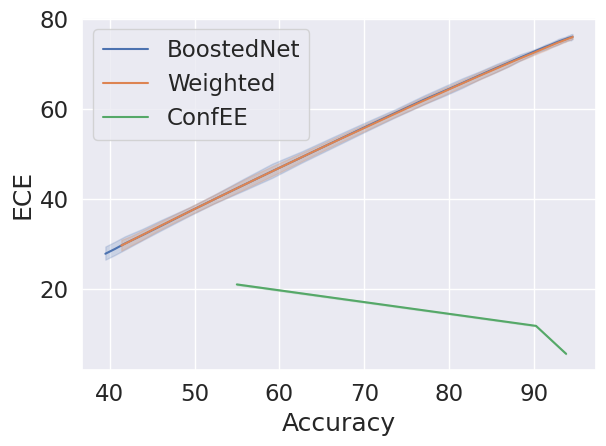

In [164]:
sns.set(font_scale=1.5)  # crazy big
sns.lineplot(data=filtered_weighted_df, x="average_ACC", y="ECE", label="BoostedNet")
sns.lineplot(data=filtered_boosted_df, x="average_ACC", y="ECE", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_ACC", y="test/gated_ece", label="ConfEE")
plt.xlabel('Accuracy')
plt.ylabel('ECE')
plt.tight_layout()
plt.savefig('perf_ece_'+dataset+'.pdf')

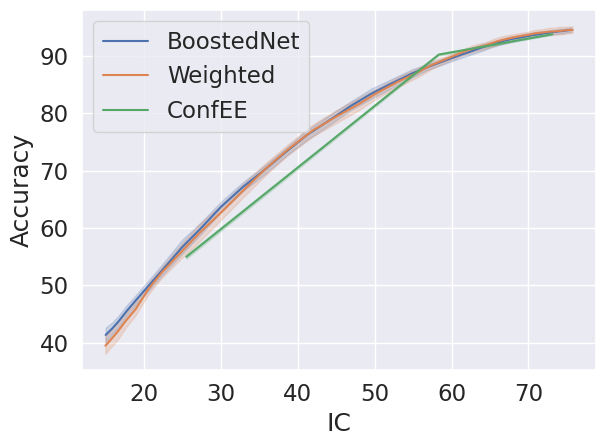

In [165]:
sns.set(font_scale=1.5) 


sns.lineplot(data=filtered_boosted_df, x="average_IC", y="ACC", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="ACC", label="Weighted")
sns.lineplot(data=filtered_our_df, x="average_IC", y="test/gated_acc", label="ConfEE")
plt.xlabel('IC')

plt.ylabel('Accuracy')
plt.tight_layout()
plt.savefig('perf_cost_'+dataset+'.pdf')

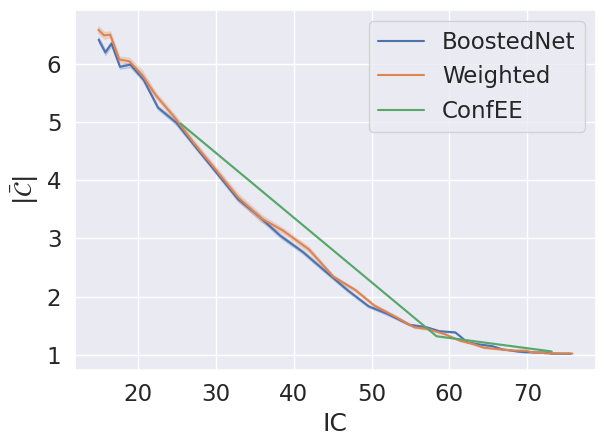

In [166]:
sns.set(font_scale=1.5)  # crazy big

sns.lineplot(data=filtered_boosted_df, x="average_IC", y="C", label="BoostedNet")
sns.lineplot(data=filtered_weighted_df, x="average_IC", y="C", label="Weighted")

sns.lineplot(data=filtered_our_df, x="average_IC", y="C", label="ConfEE")

plt.xlabel('IC')
plt.ylabel(r'$|\mathcal{\bar{C}}|$')
plt.tight_layout()
plt.savefig('inef_IC_'+dataset+'.pdf')


In [149]:
boosted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-boosted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    boosted_df_emp_vs_req = pd.concat([df_cov, boosted_df_emp_vs_req],axis=0, ignore_index=True)

weighted_df_emp_vs_req = pd.DataFrame()
for cov_key in boosted_cov_keys:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-weighted_df[cov_key]/100.0
    df_cov['requested_alpha'] = alpha
    weighted_df_emp_vs_req = pd.concat([df_cov, weighted_df_emp_vs_req],axis=0, ignore_index=True)
    
our_df_emp_vs_req = pd.DataFrame()

cov_keys_gated = []
cov_keys_gen = []
for c in cov_keys:
    if 'gen' in c:
        cov_keys_gen.append(c)
    else:
        cov_keys_gated.append(c)
for cov_key in cov_keys_gated:
    
    alpha = float(cov_key.split('cov_')[-1])
    df_cov = pd.DataFrame()
    df_cov['emp_alpha'] = 1-our_df[cov_key]
    df_cov['requested_alpha'] = alpha
    our_df_emp_vs_req = pd.concat([df_cov, our_df_emp_vs_req],axis=0, ignore_index=True)
    

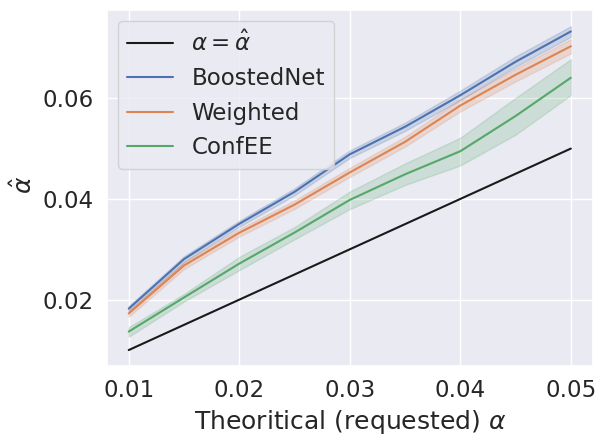

In [150]:
x = [0.01,0.05]
y = [0.01,0.05]
plt.plot(x,y, color='k',label=r'$\alpha = \hat{\alpha}$')
sns.lineplot(data=boosted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="BoostedNet")
sns.lineplot(data=weighted_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="Weighted")

sns.lineplot(data=our_df_emp_vs_req, x="requested_alpha", y="emp_alpha", label="ConfEE")

plt.xlabel(r'Theoritical (requested) $\alpha$')
plt.ylabel(r' $\hat{\alpha}$')
plt.tight_layout()
plt.savefig('emp_vs_theoritical_'+dataset+'.pdf')


In [151]:
print(keys_all_acc)
print(keys_gated_accs)
L = 6

['test/acc0', 'test/acc1', 'test/acc2', 'test/acc3', 'test/acc4', 'test/acc5', 'test/acc_exit']
['test/gated_acc_4', 'test/gated_acc_5']


In [152]:
for metrics in list_dicts_ours:
    for i, l in enumerate(range(L)):
        print(all_acc)
        gated_acc = keys_gated_accs[i]
        if gated_acc in metrics:
            
            print(metrics[gated_acc])
            print(metrics[all_acc])

test/acc0
test/acc1
test/acc2


IndexError: list index out of range